# <center>Yeezus Sentiment Analysis - Part 1</center>

## What's Up With Kanye West?
Ever since I was in middle school I've been a huge Kanye West fan. I'm talking about pink-polo, white sunglasses and backpack Kanye...the old Kanye. I don't want to get tangled into the political drama that's going on with Kanye and his relationship with Trump; however, I am concerned for Kanye's mental health since he publicly stated he's depressed. It's understandable though, he's got a lot going on his plate from being a husband to Kim K, fathering three beautiful children, running his fashion line, and other "dope shit". It seemed like he was a lot happier back when he was young and choppin' up beats and interuppting Taylor Swift at award shows...or maybe that's just what I want to believe.

### Hypothesis:
I hypothesize that Ye was significantly happier and more positive back in his early career than the current yeezy we all know today.

#### Side Note:
Unfortunately Kanye only joined twitter in 2010 which was after a lot of his big albums, so I decided to take tweets from 2010 to 2012 (before he started dating Kim K) and use that for the "old_kanye" data set and use tweets from 2017 to present for the "current_kanye" data set 

#### Update (after extracting all of Ye's tweets):
Kanye is Kanye and deletes his tweets all the time so the oldest tweets I can extract are from early April 2018 and one tweet from 2014. So I will just have to run a sentiment analysis on the data I have and won't be able to compare old and new tweets. 


### Method:
1. I'm going to extract Kanye's tweets and insert them in a table in a mysql database
    (json, tweepy, mysql_connector)
2. Query specific data to make my data set
    (pandas, mysql_connector)
3. Clean the data
    (pandas, nltk, bs4, re)
4. Calculate Sentiment Values
    (textblob)
5. Visualize the data
    (wordcloud, sklearn, pyplot, matplotlib)
6. Asess the data


### Tools:
To extract Data from Twitter:
- tweepy: twitters API that allows me to grab tweets
- json: allows me to change the extract tweets, which comes in "tweepy.models.ResultSet", then dumps it into a
  json string, then loads it into a list of dictionaries (each dictionary is a tweet containing a Tweet Object)
  
  "The Tweet object has a long list of ‘root-level’ attributes, including fundamental attributes such as 'id',
  'created_at', and 'text'. Tweet objects are also the ‘parent’ object to several child objects. Tweet child
  objects include user, entities, and extended_entities. Tweets that are geo-tagged will have a place child
  object."
  https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object.html
  
To Extract Data from twitter:
- tweepy: twitter client authentication and requests to get tweets
- json: to transfer tweet objects to dictionary

To Store Data:
- mysql: allows me to connect to database insert rows of data into my database

To Extract Data from mysql:
- mysql_connector: allows me to connect and pull data from my database
- pandas: to manipulate the data

To clean Data:
- re: helps me extract meta-characters and patterns (twitter handles, urls, encoded HTML, etc)
- bs4: decodes HTML to general text
- nltk: tokenizes words


To make the analysis I am going to use a few important libraries such as: 
- NLTK(Natural Language Toolkit): has an array of useful functions for natural language processing. 
- TextBlob: to help us calculate sentiment
- Word Cloud Library: to create some summary visualisations of our tweets



#### NLP:
Pre-Processing steps in NLP:
1. Look at char length of text, plot it, and see if there's anything odd (sanitation)  
1. Remove HTML, punctuation, special characters(twitter handlers), and stop words
2. Normalisation (stemming)
3. Tokenisation.
4. Lemmatisation
5. TF-IDF.

#### Import Necessary Libraries

In [1]:
import datetime
import time
import mysql.connector
from mysql.connector import Error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import json
from dateutil import parser

from tweepy import API
from tweepy import Cursor
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

import re

from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
import nltk

from textblob import TextBlob
from wordcloud import wordcloud, STOPWORDS

from bs4 import BeautifulSoup

import twitter_credentials
import db_info

### Database Connector
##### Function: grab_all_tweets()
Purpose: Takes in the screen name of the person you'd like to analyze on twitter and returns a dataframe of all the extracted tweets on their timeline.
Note: There is a max limit of 200 recent tweets you can grab per request using "api.user_timeline()", so i used a while loop and saved the id's of the last extracted tweet and re requested using the oldest tweet id for the "max_id" argument. Once all tweets are collected then the json is extracted from the tweet objects which  is then converted to a list of dictionary tweets. Then "extract_TWeetObjs_db()" is called to store data. Next "query_db()" is called to grab the data from the mysql and returns the dataframe of the tweets.   
##### Function: extract_TWeetObjs_db()
Purpose: Takes in the array of tweet dictionaries. Loops through each tweet extracting the following attributes: 'id', 'created_at', and 'text'and then calls "insert_query_db()" to insert the row of info into the db
##### Function: insert_query_db()
Purpose: Takes in the attributes('id', 'created_at', text'), connects to the mysql database, and executes the query to INSERT the info.
Note: 'id' = VARCHAR, 'created_at' = date, 'text' = text
##### Function: query_db()
Purpose: Connects to the mysql database, and executes the query to SELECT the info and inputs it into a dataframe.
Notes: 'id' = VARCHAR, 'created_at' = date, 'text' = text


In [2]:
class mysql_db():
    def grab_all_tweets(self, screen_name):
    
        twitter_client = TwitterClient()
        #twitter_analyzer = TwitterAnalyzer()
        api = twitter_client.get_twitter_client_api()

        #initialize a list to hol all the teets
        all_tweets = []
        
        ## Get request for 200 recent tweets from user's timeline
        new_tweets = api.user_timeline(screen_name=screen_name, count=200)
        
        ## save most recent tweets
        all_tweets.extend(new_tweets)

        ## save oldest tweet id
        oldest_tweet = all_tweets[-1].id -1
    
        ## extract all tweets from user
        while len(new_tweets) > 0:
            print("getting tweets before %s" % (oldest_tweet))
            new_tweets = api.user_timeline(screen_name=screen_name, count=200, max_id=oldest_tweet)
            
            ## save most recent tweets
            all_tweets.extend(new_tweets)
            ## update the id of oldest tweet
            oldest_tweet = all_tweets[-1].id - 1
            print("...%s tweets downloaded so far" % (len(all_tweets)))
    
        ## a string of json containing the info in all of the tweets
        status_json = json.dumps([status._json for status in all_tweets])

        ## converts string of json to a list of dictionaries, each dictionary is a tweet
        status_array = json.loads(status_json)

        ## analyzes an array containing dictionaries of tweets
        self.extract_TWeetObjs_db(status_array)
        df_kanye = self.query_db()
        return df_kanye
           
    def extract_TWeetObjs_db(self, data_array=[]):
        try:
            # loop through list of dictionary tweets and extract info
            for index in range(len(data_array)):
                data = data_array[index]
               
                #username = data['user']["screen_name"]
                id = data['id']
                #print(id)
                #print(type(id))
                created_at = time.strftime('%Y-%m-%d', time.strptime(data['created_at'],'%a %b %d %H:%M:%S +0000 %Y'))
                tweet = data['text']
                # Connect to MySql database
                self.insert_query_db(id, created_at, tweet)

        except BaseException as e:
            print("Error on_data: %s" % str(e))
    
    def insert_query_db(self, id, created_at, tweet):
        #Connects to MySQL database and inserts twitter data (make sure charset is 'utf8mb4' inorder to insert emojis)
        try:
            con = mysql.connector.connect(user=db_info.user, password=db_info.pw,
                                          host=db_info.host, database=db_info.db_name, auth_plugin=db_info.auth_name, charset = 'utf8mb4')

            if con.is_connected():
                #Insert twitter data
                cursor = con.cursor()
                #Insert twitter data
                #query = "INSERT INTO TW_table (tweet_id, created_at, tweet) VALUES (%s, %s, %s)"
                query = "INSERT INTO TW_table(tweet_id, created_at, tweet) VALUES (%s, %s, %s);"
                cursor.execute(query, (id, created_at, tweet))
                con.commit()
                #print('DEBUG: Successfully inserted twitter data to db')
            else:
                print('DEBUG: connect_db : could not connect')

        except Error as e:
            print(e)

        cursor.close()
        con.close()
        return
    
    def query_db(self):
        #Connects to MySQL database and inserts twitter data (make sure charset is 'utf8mb4' inorder to insert emojis)
        try:
            con = mysql.connector.connect(user=db_info.user, password=db_info.pw,
                                          host=db_info.host, database=db_info.db_name, auth_plugin=db_info.auth_name, charset = 'utf8mb4')

            if con.is_connected():
                cursor = con.cursor()
                query = "SELECT tweet_id, created_at, tweet FROM `TwitterDB`.`TW_table`;"
                cursor.execute(query)
                data = cursor.fetchall()
                # store in dataframe
                df = pd.DataFrame(data,columns = ['tweet_id', 'date', 'tweet'])
                print("DEBUG: Successfully queried to df")
            else:
                print('DEBUG: connect_db : could not connect')

        except Error as e:
            print(e)

        cursor.close()
        con.close()
        return df

### TWITTER CLIENT
#### Purpose:
Authenticates my credentials for the twitter API

In [3]:
class TwitterClient():
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)

        self.twitter_user = twitter_user

    def get_twitter_client_api(self):
        return self.twitter_client

### TWITTER AUTHENTICATOR

In [4]:
class TwitterAuthenticator():
    def authenticate_twitter_app(self):
        auth = OAuthHandler(twitter_credentials.CONSUMER_KEY,
                            twitter_credentials.CONSUMER_SECRET)
        auth.set_access_token(twitter_credentials.ACCESS_TOKEN,
                              twitter_credentials.ACCESS_TOKEN_SECRET)
        return auth

### TWITTER ANALYZER
Purpose: takes in a tweet and uses TextBlob to determine polarity.
Note:
(POLARITY > 0)  =====> tweet is positive
(POLARITY == 0) =====> tweet is neutral
(POLARITY < 0)  =====> tweet is negative


In [5]:
class TwitterAnalyzer():

    # Functionality for analyzing and categorizing content from tweets
    def analyze_sentiment(self, tweet):
        analysis = TextBlob(tweet)

        if analysis.sentiment.polarity > 0:
            return 1
        elif analysis.sentiment.polarity == 0:
            return 0
        else:
            return -1

### Main Function

In [6]:
if __name__ == "__main__":
    db = mysql_db()
    old_df = db.grab_all_tweets("kanyewest")

getting tweets before 1073914408563167231
...396 tweets downloaded so far
getting tweets before 1064230822952099840
...588 tweets downloaded so far
getting tweets before 1047479529810194431
...788 tweets downloaded so far
getting tweets before 1038992296769777664
...988 tweets downloaded so far
getting tweets before 990336500058406911
...1170 tweets downloaded so far
getting tweets before 501492019328745471
...1170 tweets downloaded so far
DEBUG: Successfully queried to df


## Preprocessing and Cleaning
First let's take a peak at the data to see how it's looking

In [7]:
old_df.head()
print('--------General Info & Shape of Dataframe--------')
print(old_df.info())
print(old_df.shape)
print('--------Head Of Dataframe--------')
old_df.head()

--------General Info & Shape of Dataframe--------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170 entries, 0 to 1169
Data columns (total 3 columns):
tweet_id    1170 non-null object
date        1170 non-null object
tweet       1170 non-null object
dtypes: object(3)
memory usage: 27.5+ KB
None
(1170, 3)
--------Head Of Dataframe--------


,tweet_id,date,tweet
0,1080212949464043520,2019-01-01,One of my favorite of many things about what t...
1,1080211582955663360,2019-01-01,Spoke with Joe Rogan Podcast coming soon🔥🔥🔥
2,1080209800846176256,2019-01-01,From now on I’m performing with my mutherfucki...
3,1080206689469489153,2019-01-01,RT @Maha_Sattva: @kanyewest https://t.co/RDqTE...
4,1080206642040340481,2019-01-01,Love everyone Start the year clean J...


## Pre Data Cleaning (Sanity Check)
I'm going to check the length of each tweet string.
Using a box plot I can display the overall distribution of the amount of characters in each tweet.
The purpose of this sanity check is to ensure the character count is normal (not above 140 characters).
### Sanity Check Results:
The box plot shows that the median char count is slightly below 60 and there are are some tweets that are beyond the 140 character max.

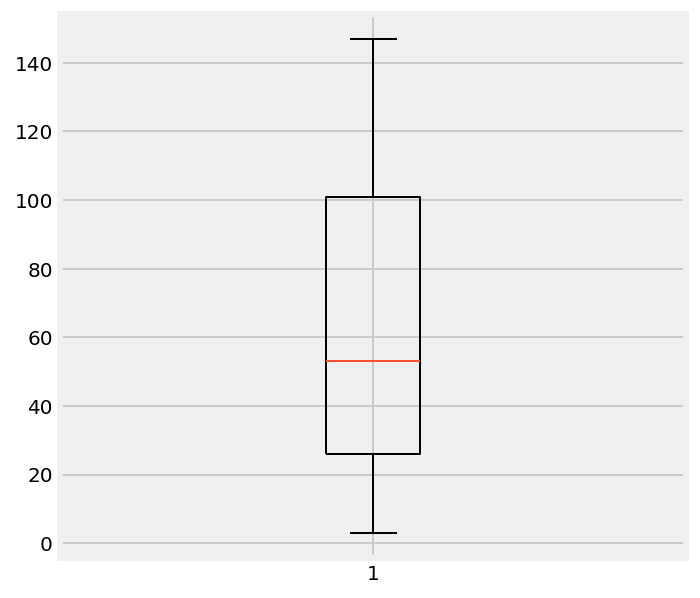

In [8]:
old_df['sanity_check_length'] = [len(text) for text in old_df.tweet]
figure, axis = plt.subplots(figsize=(5,5))
plt.boxplot(old_df.sanity_check_length)
plt.show()

In [9]:
over_max = old_df[old_df.sanity_check_length > 140]
over_max

,tweet_id,date,tweet,sanity_check_length
469,1057232228353273856,2018-10-30,RT @070Updates: PSA:🚨\n\n“GHOST TOWN” @kanyewe...,144
470,1057232027995553794,2018-10-30,RT @KimKardashian: Please check out exclusive ...,144
471,1057232012115873792,2018-10-30,RT @KimKardashian: Watch the full episodes &am...,144
476,1056998627737042944,2018-10-29,RT @KimKardashian: #KKWBODY III (UNISEX) is a ...,144
477,1056989384438890496,2018-10-29,RT @butsmallhead: Yes hello @kanyewest 👋🎙 than...,144
645,1045315452753199104,2018-09-27,Dojo\nA dōjō (道場 &lt;https://t.co/BMDKrR5vzG&g...,146
912,1004430170189467648,2018-06-06,RT @KimKardashian: So grateful to @realDonaldT...,147


In [10]:
 for i in over_max.tweet:
    print (i)

RT @070Updates: PSA:🚨

“GHOST TOWN” @kanyewest feat. @070shake &amp; @partynextdoor 

is now certified GOLD. 📀

#070 
#YE https://t.co/6DBLusdP…
RT @KimKardashian: Please check out exclusive interviews now on https://t.co/HMG1Wp4dJY site! Everyone needs to get out &amp; vote now!  #youar…
RT @KimKardashian: Watch the full episodes &amp; more at https://t.co/HMG1Wp4dJY #youareenough #yourvotecounts #bewoke.vote  #empoweryourself h…
RT @KimKardashian: #KKWBODY III (UNISEX) is a modern, woody floral opening with Pink &amp; Black Pepper and finishes with layers of creamy Sand…
RT @butsmallhead: Yes hello @kanyewest 👋🎙 thank much for follow! 👀 we just want make world laugh &amp; it great to get support from Ye. As rewa…
Dojo
A dōjō (道場 &lt;https://t.co/BMDKrR5vzG&gt;) is a hall or space for immersive learning or meditation. This is traditi… https://t.co/Y89keTfn2t
RT @KimKardashian: So grateful to @realDonaldTrump, Jared Kushner &amp; to everyone who has showed compassion &amp; contributed 

### After printing out the tweets that are beyond 140 char max limit, I can see that the reason for this is because of the special characters (html encoding) that were hidden and added when retweeted.

## Data Cleaning Process
### Let's do the following:
##### 1) Decode HTML to general text
##### 1) Remove URL links (http, www, etc)
##### 2) RemoveTwitter handles
##### 3) Remove punctuation, speical characters, and numbers
##### 4) Make lower case
##### 5) Remove stop words
##### 6) Tokenize

In [11]:
## raw string patterns
pat_t_handle = r'@[A-Za-z0-9_]+'
pat_url_1 = r'https?://[^ ]+'
pat_url_2 = r'www.[^ ]+'
pat_RT = r'RT'
pat_rt = r'rt'
all_patterns = r'|'.join((pat_t_handle, pat_url_1, pat_url_2, pat_RT, pat_rt))
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not",
                 "weren't":"were not","haven't":"have not","hasn't":"has not","hadn't":"had not",
                 "won't":"will not","wouldn't":"would not", "don't":"do not", "doesn't":"does not",
                 "didn't":"did not","can't":"can not","couldn't":"could not","shouldn't":"should not",
                 "mightn't":"might not","mustn't":"must not"}
pat_neg = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')
#exclude_list = ['RT', 'rt']

def tweet_cleaner(dirty_text):
    soup = BeautifulSoup(dirty_text, 'lxml')
    souped_tweets = soup.get_text()
    stripped_tweets = re.sub(all_patterns, '', souped_tweets)
    #no_retweets = re.sub(exclude_list, '', stripped_tweets)
    lower_case = stripped_tweets.lower()
    neg_handled = pat_neg.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    ## creates unnecessary white spaces, During tokenization I'll remove them later
    words = [x for x in tok. tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [14]:
## create TwitterAnalyzer instant

print ("Data Cleaning Initiated...")
cleaned_tweets = []
## clean tweets
for i in range(0,len(old_df)):
    cleaned_tweets.append(tweet_cleaner(old_df.tweet[i]))

print("Data Cleaning Finished...\n")

Data Cleaning Initiated...
Data Cleaning Finished...



In [15]:
clean_df = pd.DataFrame(cleaned_tweets,columns=['cleaned_tweets'])

old_df['cleaned_tweets'] = [text for text in clean_df.cleaned_tweets]
old_df = old_df.drop(['sanity_check_length'], axis='columns')
old_df.rename(columns={'tweet':'original_tweets'}, inplace=True)
old_df.head(20)


,tweet_id,date,original_tweets,cleaned_tweets
0,1080212949464043520,2019-01-01,One of my favorite of many things about what t...,one of my favorite of many things about what t...
1,1080211582955663360,2019-01-01,Spoke with Joe Rogan Podcast coming soon🔥🔥🔥,spoke with joe rogan podcast coming soon
2,1080209800846176256,2019-01-01,From now on I’m performing with my mutherfucki...,from now on performing with my mutherfucking h...
3,1080206689469489153,2019-01-01,RT @Maha_Sattva: @kanyewest https://t.co/RDqTE...,
4,1080206642040340481,2019-01-01,Love everyone Start the year clean J...,love everyone sta the year clean just be all love
5,1080206417523429376,2019-01-01,RT @yetaughtni: Honestly felt like the TL need...,honestly felt like the tl needed this words of...
6,1080206353308692480,2019-01-01,RT @JordanPrileszky: Rolling into 2019 with a ...,rolling into with line up of my favourite illu...
7,1080206247981309952,2019-01-01,RT @rihsnake: DOPE https://t.co/CcDM9W3h08,dope
8,1080206155811414016,2019-01-01,RT @BasedCharlie: Drake telling OVO fest that ...,drake telling ovo fest that kanye is his bigge...
9,1080206130041651200,2019-01-01,RT @ima_fix_wolves: @kanyewest KANYE KANYE KAN...,kanye kanye kanye wanna frame kids see ghosts ...


#### I noticed some cells tweet columns were blank, I comared the "pre_clean_df" to "clean_df" tweet columns and saw that the blank rows are because they were retweets with no words just a url or video link. So I decided to delete all blank rows before I ran the sentiment analysis.

In [16]:
zeros_index = old_df[old_df.cleaned_tweets == ''].index.tolist()
old_df.drop(zeros_index, inplace=True)
print(old_df.info())
old_df.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 966 entries, 0 to 1169
Data columns (total 4 columns):
tweet_id           966 non-null object
date               966 non-null object
original_tweets    966 non-null object
cleaned_tweets     966 non-null object
dtypes: object(4)
memory usage: 37.7+ KB
None


,tweet_id,date,original_tweets,cleaned_tweets
0,1080212949464043520,2019-01-01,One of my favorite of many things about what t...,one of my favorite of many things about what t...
1,1080211582955663360,2019-01-01,Spoke with Joe Rogan Podcast coming soon🔥🔥🔥,spoke with joe rogan podcast coming soon
2,1080209800846176256,2019-01-01,From now on I’m performing with my mutherfucki...,from now on performing with my mutherfucking h...
4,1080206642040340481,2019-01-01,Love everyone Start the year clean J...,love everyone sta the year clean just be all love
5,1080206417523429376,2019-01-01,RT @yetaughtni: Honestly felt like the TL need...,honestly felt like the tl needed this words of...
6,1080206353308692480,2019-01-01,RT @JordanPrileszky: Rolling into 2019 with a ...,rolling into with line up of my favourite illu...
7,1080206247981309952,2019-01-01,RT @rihsnake: DOPE https://t.co/CcDM9W3h08,dope
8,1080206155811414016,2019-01-01,RT @BasedCharlie: Drake telling OVO fest that ...,drake telling ovo fest that kanye is his bigge...
9,1080206130041651200,2019-01-01,RT @ima_fix_wolves: @kanyewest KANYE KANYE KAN...,kanye kanye kanye wanna frame kids see ghosts ...
10,1080206103969914880,2019-01-01,RT @TrvppyHippy: had to snap real quick ya fee...,had to snap real quick ya feel me


## Sentiment Analyzer

In [17]:
analyzer = TwitterAnalyzer()
old_df['sentiment'] = np.array([analyzer.analyze_sentiment(x) for x in old_df['cleaned_tweets']])
print(old_df['sentiment'].head())
old_df.to_csv("cleaned_kanye_tweets.csv")

0    1
1    0
2    0
4    1
5    1
Name: sentiment, dtype: int64
